In [1]:
# import Python modules for scientific computing and plotting 
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# import the CosmoBolognaLib
import CosmoBolognaLib as cbl
from CosmoBolognaLib import DoubleVector as dv

In [3]:
# set the CosmoBolognaLib and the current directories
cbl.SetDirs(os.getcwd()+"/../../../", os.getcwd()+"/")

In [4]:
# create an object of class Cosmology
cosmo = cbl.Cosmology(cbl.CosmologicalModel__Planck15_)
cosmo.set_sigma8(0.8)

In [5]:
# define k and r for the computation of dark matter power spectrum and  two point correlation correlation function
kk = np.logspace(-5, 3, 1024) 

In [6]:
# compute the power spectrum using CAMB
pkCAMB = np.array([cosmo.Pk(_kk, "CAMB", False, 0, ) for _kk in kk])

In [7]:
# compute the power spectrum using EisensteinHu
pkEH = np.array([cosmo.Pk(_kk, "EisensteinHu", False, 0) for _kk in kk])

In [8]:
# compute the no wiggles power spectrum using the b-spline procedure described in Vlah et al 2015
#https://arxiv.org/abs/1509.02120

pknw_bspline = []
knots = [9, 10, 11, 12, 13, 14, 15, 16]
for kn in knots:
    pknw_bspline.append(np.array(cosmo.Pk_matter_NoWiggles_bspline (kk, dv(pkCAMB), dv(pkEH), 4, kn)))

mean_bspline = np.mean(pknw_bspline, axis=0)

In [22]:
# compute the no wiggles power spectrum using 3D gaussian smoothing procedure described in Vlah et al 2015
#https://arxiv.org/abs/1509.02120

lam = 0.05
pknw_gaussian_3d = np.array(cosmo.Pk_matter_NoWiggles_gaussian (kk, dv(pkCAMB), dv(pkEH), lam, "gaussian_3d"))

In [23]:
# compute the no wiggles power spectrum using 1D gaussian smoothing procedure described in Vlah et al 2015
#https://arxiv.org/abs/1509.02120

lam = 0.25
pknw_gaussian_1d = np.array(cosmo.Pk_matter_NoWiggles_gaussian (kk, dv(pkCAMB), dv(pkEH), lam, "gaussian_1d"))

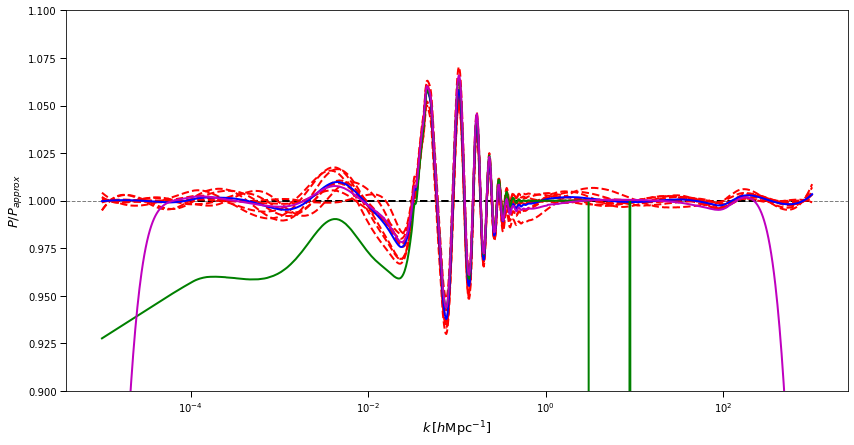

In [30]:
#plot the oscillatory part of the power spectrum
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(14, 7))

ax.set_xscale("log")
ax.set_ylim(0.9, 1.1)        
ax.set_xlabel(r"$k \, [h \mathrm{Mpc}^{-1}]$", fontsize=13)
ax.set_ylabel(r"$P/P_{approx}$", fontsize=13)
ax.axhline(1., ls='--', color="0.5", lw=1)
ax.plot(kk, pkCAMB/pkCAMB, ls="--", lw=2, color="k")

for pk in pknw_bspline:
    ax.plot(kk, pk/pkCAMB, ls="--", lw=2, color="r")

ax.plot(kk, mean_bspline/pkCAMB, ls="-", lw=2, color="b")
ax.plot(kk, pknw_gaussian_3d/pkCAMB, ls="-", lw=2, color="g")
ax.plot(kk, pknw_gaussian_1d/pkCAMB, ls="-", lw=2, color="m")

In [28]:
#Compute 2pcf monopole

rr = np.linspace(1, 200, 100)
xiCAMB = np.array(cbl.transform_FFTlog(rr, 1, dv(kk), dv(pkCAMB), 0))
xiEH = np.array(cbl.transform_FFTlog(rr, 1, dv(kk), dv(pkEH), 0))
xi_bspline = np.array(cbl.transform_FFTlog(rr, 1, dv(kk), dv(mean_bspline), 0))
xi_damped_old = np.array(cbl.transform_FFTlog(rr, 1, dv(kk),\
                                              pkEH+np.exp(-10**2*kk**2/2)*(pkCAMB-mean_bspline), 0))

xi_damped_new = np.array(cbl.transform_FFTlog(rr, 1, dv(kk),\
                                              mean_bspline+np.exp(-10**2*kk**2/2)*(pkCAMB-mean_bspline), 0))


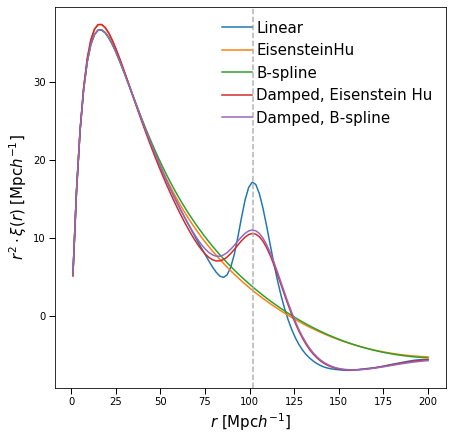

In [29]:
#Plot 2PCF monopole
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.set_xlabel(r"$r \, \, [\mathrm{Mpc} h^{-1}] $", fontsize=15)
ax.set_ylabel(r"$r^2 \cdot \xi(r) \, \, [\mathrm{Mpc} h^{-1}]$", fontsize=15)

ax.plot(rr, xiCAMB*rr*rr, label="Linear")
ax.plot(rr, xiEH*rr*rr, label="EisensteinHu")
ax.plot(rr, xi_bspline*rr*rr, label="B-spline")
ax.plot(rr, xi_damped_old*rr*rr, label="Damped, Eisenstein Hu")
ax.plot(rr, xi_damped_new*rr*rr, label="Damped, B-spline")

ax.axvline(101.7, color="0.7", ls="--")
_ = ax.legend(loc="best", fontsize=15)
